# Analysis : 

Your task is to create a figure, or set of related figures, that tell an interesting story about Capital Metro ridership patterns around the UT-Austin campus during the semester in question. Provide a clear annotation/caption for each figure, but the figure(s) should be more or less stand-alone, in that you shouldn't need many, many paragraphs to convey its meaning. Rather, the figure together with a concise caption should speak for itself as far as possible.

You have broad freedom to look at any variables you'd like here -- try to find that sweet spot where you're showing genuinely interesting relationships among more than just two variables, but where the resulting figure or set of figures doesn't become overwhelming/confusing. (Faceting/panel plots might be especially useful here.)  

### Data Snapshot :
Data from Austin's own Capital Metro bus network, including shuttles to, from, and around the UT campus. 
These data track ridership on buses in the UT area. Ridership is measured by an optical scanner that counts how many people embark and alight the bus at each stop. 

Each row in the data set corresponds to a 15-minute period between the hours of 6 AM and 10 PM, each and every day, from September through November 2018.

#### The variables are:
  ###### 1.) timestamp: the beginning of the 15-minute window for that row of data
  ###### 2.) boarding: how many people got on board any Capital Metro bus on the UT campus in the specific 15 minute window
  ###### 3.) alighting: how many people got off ("alit") any Capital Metro bus on the UT campus in the specific 15 minute window
  ###### 4.) day_of_week and weekend: Monday, Tuesday, etc, as well as an indicator for whether it's a weekend.
  ###### 5.) temperature: temperature at that time in degrees F
  ###### 6.) hour_of_day: on 24-hour time, so 6 for 6 AM, 13 for 1 PM, 14 for 2 PM, etc.
  ###### 7.) month: July through December

## Goal : EDA and story telling using Viz for Capital Metro ridership patterns

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
# Load the data
data = pd.read_csv('capmetro_UT.csv')

In [6]:
data[0:7]

,timestamp,boarding,alighting,day_of_week,temperature,hour_of_day,month,weekend
0,2018-09-01 06:00:00,0,1,Sat,74.82,6,Sep,weekend
1,2018-09-01 06:15:00,2,1,Sat,74.82,6,Sep,weekend
2,2018-09-01 06:30:00,3,4,Sat,74.82,6,Sep,weekend
3,2018-09-01 06:45:00,3,4,Sat,74.82,6,Sep,weekend
4,2018-09-01 07:00:00,2,4,Sat,74.39,7,Sep,weekend
5,2018-09-01 07:15:00,4,4,Sat,74.39,7,Sep,weekend
6,2018-09-01 07:30:00,3,12,Sat,74.39,7,Sep,weekend


In [6]:
data.describe()

,boarding,alighting,temperature,hour_of_day
count,5824.000000,5824.000000,5824.000000,5824.000000
mean,51.511676,47.646291,69.282473,13.500000
std,48.820284,50.069866,13.540249,4.610168
min,0.000000,0.000000,29.180000,6.000000
25%,13.000000,13.000000,59.195000,9.750000
50%,33.000000,28.000000,72.750000,13.500000
75%,79.250000,64.000000,79.290000,17.250000
max,288.000000,304.000000,97.640000,21.000000


###### No nulls

In [7]:
data.isnull().sum()

timestamp      0
boarding       0
alighting      0
day_of_week    0
temperature    0
hour_of_day    0
month          0
weekend        0
dtype: int64

In [11]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

#### Is there any peak time for boardings and deboardings?

In [20]:
data.groupby('hour_of_day')['boarding','alighting'].agg(sum)

,boarding,alighting
hour_of_day,,
6,1623,4343
7,4257,24656
8,6332,37624
9,8826,42184
10,12839,32969
11,15119,21183
12,21057,20241
13,21560,16790
14,27540,14344


#### Is there any role of temperatures in boarding?

In [32]:
data['temperature_bin'] = data['temperature'].apply(lambda x: 'Above 60' if x > 60 else 'Below 60')
result = data.groupby('temperature_bin')['boarding'].count()
print(result)

temperature_bin
Above 60    4248
Below 60    1576
Name: boarding, dtype: int64


### Exploratory Data Analysis (EDA)

C:\Users\Deepti\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The handle <matplotlib.patches.Patch object at 0x00000281BEE116D8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  **kwargs)


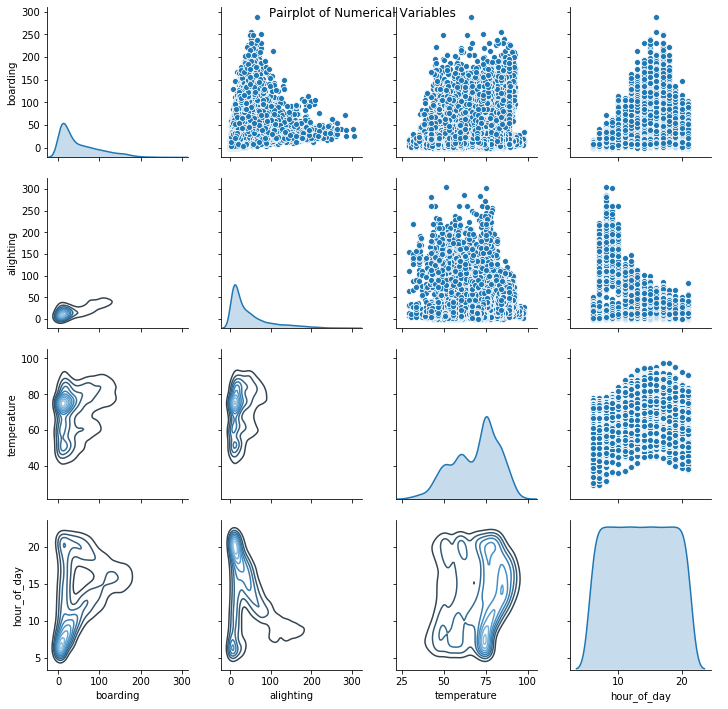

In [10]:
# Pairplot for numerical variables
g = sns.PairGrid(data=data[['boarding', 'alighting', 'temperature', 'hour_of_day']])
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, shade=True)
g.map_lower(sns.kdeplot, cmap='Blues_d')
g.add_legend()
plt.suptitle('Pairplot of Numerical Variables')
plt.show()

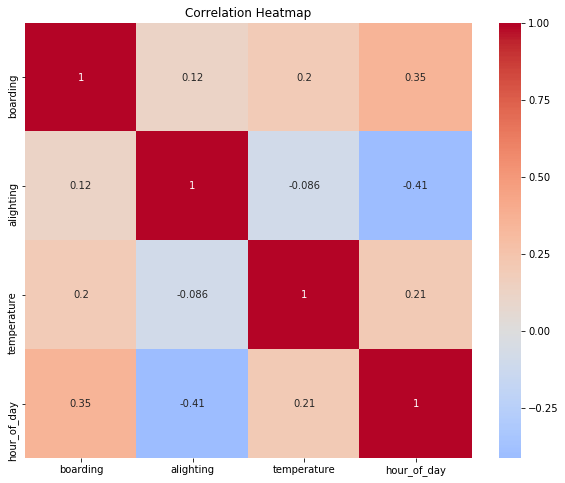

In [11]:
# Correlation heatmap
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

#### EDA Findings :
#1.) Boarding is highly correlated positively to hour_of_day.
#2.) Boarding is positively correlated to temperature.
#3.) Hour of the day is also positively correlated to temperature.
#4.) Boarding & alighting are positively correlated.
#5.) Alighting & hour of day are highly correlated  negatively.
#6.) Alighting & temperature are negatively correlated.

## Regression Analysis

In [12]:
# Select relevant features
features = ['alighting', 'temperature', 'hour_of_day', 'month', 'weekend']
X = data[features]
y = data['boarding']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, columns=['month', 'weekend'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Coefficients and Intercept
coefficients = reg_model.coef_
intercept = reg_model.intercept_
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Mean Squared Error: 1514.66
Coefficients: [  0.06788719   0.88656913   3.4879864   -4.63601872 -13.00246591
 -51.00684557]
Intercept: -40.061000044063796


In [14]:
# Create a dictionary to map feature names to their coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Display the feature names with their coefficients
for feature, coeff in feature_coeff_dict.items():
    print(f"{feature}: {coeff:.4f}")

alighting: 0.0679
temperature: 0.8866
hour_of_day: 3.4880
month: -4.6360
weekend: -13.0025


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to show feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print('\nFeature Importances:')
print(feature_importance_df)

Mean Squared Error: 522.11

Feature Importances:
           Feature  Importance
2      hour_of_day    0.439063
0        alighting    0.362888
5  weekend_weekend    0.105076
1      temperature    0.080585
3        month_Oct    0.007618
4        month_Sep    0.004771


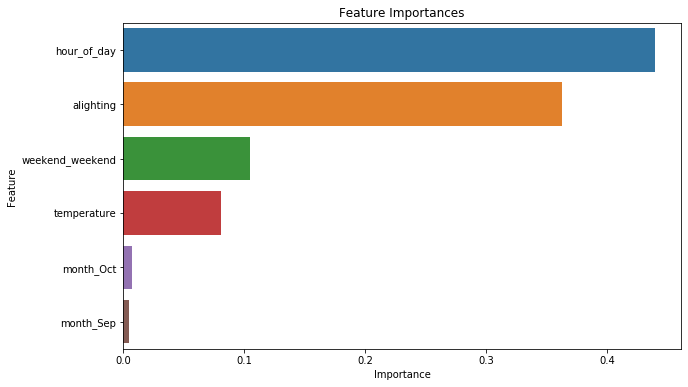

In [23]:
# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Conclusion : 

A lower MSE indicates a better fit to the data. So, Random Forest model is performing well.

##### 1.) At University, a lot of classes are held.Since it suggests that specific hours, such the start and conclusion of courses, have a stronger impact on ridership, the feature "hour_of_day" is crucial.Prior to the start of classes, at lunchtime, and immediately following the completion of classes are peak times. Because many students may be boarding and getting off at this time, the most traffic can be anticipated.

##### 2.) Feature "temperature" is highly important, it indicates that temperature affects the number of riders.Higher temperatures are associated with more riders, suggesting that warmer weather leads to increased bus ridership.

##### 3.) In contrast to the weekdays, when most students may only be traveling to UT Austin to attend classes, ridership is more noticeable on weekends, when students may be taking rides to acquire groceries, go shopping, etc.

##### 4.) Oct and Sept are months in which ridership has been seen significantly more.